## 1\. Contexto

Nosso problema tem como objetivo ajudar a Loggi a tomar decisões de logística mais eficientes para as entregas em todo o território do Distrito Federal. Para isso, precisamos identificar e analisar números relevantes que possam fornecer insights valiosos e embasar as decisões da Loggi.

## 2\. Pacotes e bibliotecas

Estrutura do arquivo



```
# Essa é a estrutura do arquivo deliveries.json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...
```



Vamos precisar de alguns pacotes para que esse codigo funcione de maneira correta

Importando Pacotes

In [2]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import numpy as np
import os

Abrindo o arquivo

In [3]:
with open('deliveries.json', mode='r', encoding='utf8') as arquivo:
    deliveries_bruto = json.load(arquivo)

Checagem inicial do arquivo json

In [4]:
#Quantidade de linhas
len(deliveries_bruto)

199

In [5]:
#Nome das colunas
checagem = deliveries_bruto[0]
print(checagem.keys())

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])


In [6]:
#Puxando região
checagem['region']

'df-2'

In [7]:
#Puxando longitude do hub
checagem['origin']['lng']

-48.05498915846707

In [8]:
#Puxando latitude do destino
checagem['deliveries'][0]['point']['lat']

-15.848929154862294

Tudo OK, Com isso podemos garantir que o arquivo está sendo lido da forma correta

## 3\. Exploração de dados

Wragling da Estrutura

###Vamos conhecer nossa estrutura: temos um DataFrame chamado deliveries_df. Nele, encontramos as seguintes informações:

In [9]:
deliveries_df = pd.DataFrame(deliveries_bruto)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


*   O nome dos hubs está na coluna "name".
*   As três regiões do Distrito Federal estão na coluna "region".
*   A localização de cada hub está na coluna "origin".
*   A capacidade total dos veículos de cada hub está na coluna "vehicle_capacity".
*   As entregas estão registradas na coluna "deliveries".


In [10]:
#Quebrando origin do hub em lagitude e logitude para 2 colunas diferentes
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


In [11]:
#Integrando a localização de latitude e longitude do hub na tabela deliveries_df
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [12]:
# Agora precisamos inserir lng e lat onde estava origin
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.head()

,name,region,lng,lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [13]:
# Vamos renomear as colunas para uma melhor orientação
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [14]:
# Em cada linha do dataframe em deliveries existe uma lista de entregas, precisamos ajustar ao nosso dataframe para uma melhor analise
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [15]:
# Aqui vamos fazer a seguinte operação, vamos separar latitude e longitude de deliveries e encontrar o delivery_size que é a quantidade de cada veiculo de entrega
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Vamos fazer mais algumas checagens nos 2 DataFrames

In [16]:
# Depois dessa operação vimos que o numero de linhas agora cresceu bastante em comparação ao dataframe deliveries_df
len(deliveries_normalized_df)

636149

In [17]:
# Agora vamos checar a quantidade de linhas em deliveries_df
len(deliveries_df)

199

In [18]:
deliveries_normalized_df.columns

Index(['delivery_size', 'delivery_lng', 'delivery_lat'], dtype='object')

In [19]:
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'deliveries'],
      dtype='object')

Ok, agora precisamos unir os 2 datadrames a um dataframe apenas
Vamos unir os 2 e colocar-los em deliveries_df

In [20]:
# Operação que exclui a coluna deliveires e junta as 2 colunas em uma só
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [21]:
# Agora vamos checar as linhas desse nosso dataframe
len(deliveries_df)

636149

In [22]:
# Agora o numero das linhas e colunas
deliveries_df.shape

(636149, 8)

In [23]:
# Agora os nomes de cada coluna
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [24]:
# Agora precisamos de um diagnostico completo do dataframe para garantir a qualidade dos dados
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


Vemos que nosso arquivo tem agora aproximadamente 38.8 MB
* 4 colunas do tipo float (As coordenadas)
* 2 do tipo int (Capacidades)
* 2 do tipo object que são apenas textos categoricos que são o nome e a região

##Agora com nosso dataframe limpo e setado podemos tirar algumas primeiras informações muito uteis sobre o dataframe

In [25]:
# Vamos descobrir o que tem nos dados do tipo object
type_object = deliveries_df.select_dtypes("object").describe().transpose()
type_object.columns = ['Linhas', 'Valores Únicos', 'Mais repetidos', 'Repetições']
type_object.index = ['Hub', 'Região df']
type_object

,Linhas,Valores Únicos,Mais repetidos,Repetições
Hub,636149,199,cvrp-1-df-87,5636
Região df,636149,3,df-1,304708


* Com as infomações extraidas acima podemos observar que ambas as colunas tem 636.149 linhas com informações, o que é uma exelente informação pra nossa analise, assim garantimos que os dados são concretos para cada hub e região

* Em Valores Únicos podemos analisar que existem 199 hubs da Loggi no distrito federal e 3 regiões

* Em Mais repetidos, podemos ver que o hub "cvrp-1-df-87" é o hub da Loggi com a maior quantidade de entregas e que a região com mais entregas é o a região df-1 que é a região central do distrito federal e onde fica a cidade de Brasilia

* Em Repetições, podemos ver quantas vezes o Hub cvrp-1-df-87 se repete na tabela e quantas vezes o df-1 se repete (Isso quer dizer que o cvrp-1-df-87 tem um total de 5.636 entregas e que a região df-1 tem um total de 304.708 entregas

##Não que seja algo util, mais é importante também para garantir a integridade dos dados fornecidos

In [26]:
# Vamos analisar o que temos nos dados do tipo float (Apenas Coordenadas)
type_float = deliveries_df.select_dtypes("float").describe().transpose()
type_float = type_float.drop(['std'] ,axis=1)
type_float.columns = ['Linhas', 'Média Coordenadas', 'Minimo','25%', '50%', '75%', 'Maximo']
type_float

,Linhas,Média Coordenadas,Minimo,25%,50%,75%,Maximo
hub_lng,636149.0,-47.949902,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
delivery_lng,636149.0,-47.946087,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


##Então por que não checar também os dados do tipo int?

In [27]:
type_int = deliveries_df.select_dtypes("int64").describe().transpose()
type_int = type_int.drop(['std'] ,axis=1)
type_int.columns = ['Linhas', 'Média', 'Minimo','25%', '50%', '75%', 'Maximo']
type_int.index = ['Capacidade do Hub', 'Cada Veiculo']
type_int

,Linhas,Média,Minimo,25%,50%,75%,Maximo
Capacidade do Hub,636149.0,180.000000,180.0,180.0,180.0,180.0,180.0
Cada Veiculo,636149.0,5.512111,1.0,3.0,6.0,8.0,10.0


* Novamente podemos garantir que existem 636.149 linhas em ambos

* A Média da capacidade do hub, e média das capacidades das entregas

* O minimo e o maximo das capacidades, que da pra ter uma noção de que não especificado o que quer dizer essa capacidade, é apenas um numero inteiro fornecido (Por tanto deixaremos do jeito que está)

In [28]:
# Checando se no dataframe existe algum valor nulo
deliveries_df.notna().any()

name                True
region              True
hub_lng             True
hub_lat             True
vehicle_capacity    True
delivery_size       True
delivery_lng        True
delivery_lat        True
dtype: bool

Podemos ver que nosso dataframe está completamente preenchido por dados (exelente noticia)
Ok, vamos continuar para podemos extrair mais informações

#Agora vamos trabalhar com geopandas (gpd) para dados geograficos

In [29]:
# Primeiro usando o geopandas vamos ver o que extraimos de dentro de "distrito-federal.shp"
mapa = gpd.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Vemos que extraimos uma lista de cordenadas geograficas das entregas

In [30]:
# Vamos selecionar apenas as colunas que nos interessam nesse momento
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = gpd.GeoDataFrame(hub_df, geometry=gpd.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [31]:
# Criamos um novo dataframe chamado geo_deliveries_df e nesse adicionamos cada ponto de entrega
geo_deliveries_df = gpd.GeoDataFrame(deliveries_df, geometry=gpd.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055,POINT (-48.11490 -15.85805)


#Tudo pronto, todos nossos dados estão nos conformes, vamos para as analises graficas que assim teremos uma noção maior do que esses dados querem dizer
Importante resaltar que por se tratar de longa lista de dados de entregas, a criação dos graficos podem demorar de 2 a 5 minutos em média, peço um pouco de paciencia

obs - você pode clicar em executar tudo e voltar daqui a alguns minutos que o codigo irá criar varias imagens

##1 - Vamos começar analisando a quantidade de entregas por região

C:\Users\jacks\AppData\Local\Temp\ipykernel_10832\3520489365.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:
C:\Users\jacks\AppData\Local\Temp\ipykernel_10832\3520489365.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('insights/Entregas-no-Distrito-Federal-por-Região.png', dpi=500, bbox_inches='tight')
C:\Users\jacks\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


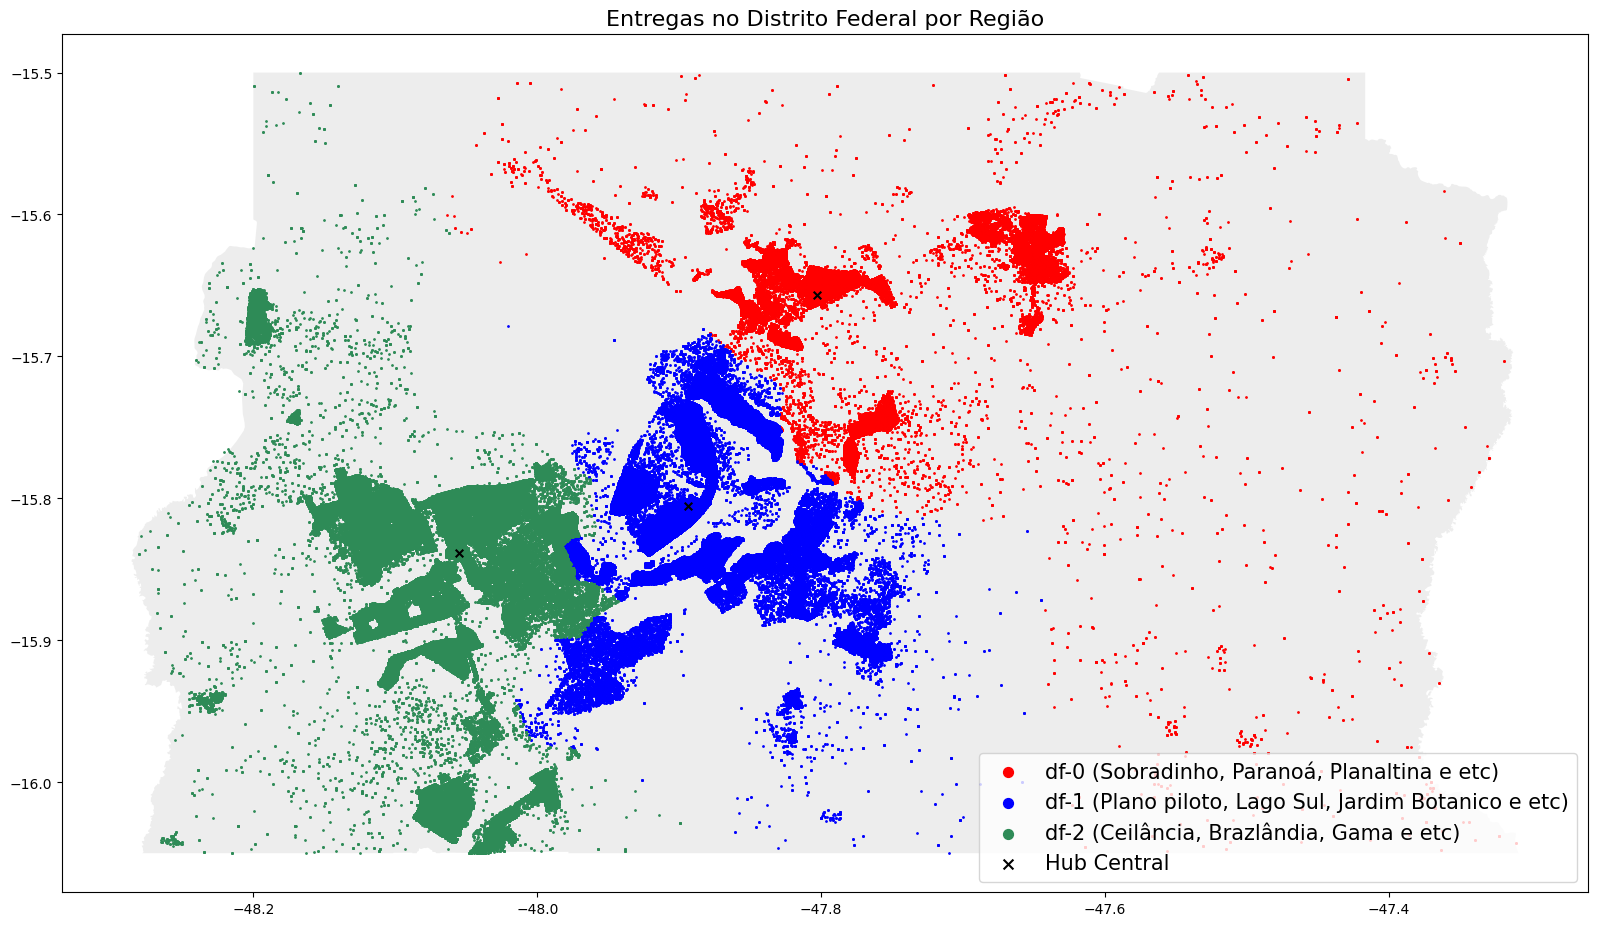

In [33]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0 (Sobradinho, Paranoá, Planaltina e etc)")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1 (Plano piloto, Lago Sul, Jardim Botanico e etc)")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2 (Ceilância, Brazlândia, Gama e etc)")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="Hub Central")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])
plt.savefig('Graficos/Entregas-no-Distrito-Federal-por-Região.png', dpi=500, bbox_inches='tight')
plt.show()

Aqui podemos obter uma visão mais clara da situação que estávamos analisando anteriormente. Agora, com as coordenadas geográficas, podemos visualizar, em um mapa de Brasília, todos os pontos de entrega em cada região.

* Na região DF-1, que inclui Brasília (Plano Piloto), podemos observar o grande número de entregas anteriormente mencionado. Isso ocorre porque é a região mais movimentada do Distrito Federal, com a maior concentração da população.

* Na região DF-2, os dados revelam que as entregas são bastante concentradas em Vicente Pires, Taguatinga e Águas Claras. Além disso, essa região abrange áreas mais afastadas, como Brazlândia e Gama.

* Por fim, temos a região DF-0, que possui a menor densidade populacional do DF, mas abrange a maior parte das áreas rurais e mais afastadas.

Essas informações fornecem um panorama mais completo da distribuição das entregas em cada região.

#Certo, Mais qual será a porcentagem de entragas por cada região?

In [34]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.columns = ['Região', '|Capaciade do Hub', '|Percentual de Entregas']
data.head()

,Região,|Capaciade do Hub,|Percentual de Entregas
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


Aqui podemos perceber o quanto uma região é superior a outra em relação
a quantidade de entregas
* df-1 com 47%
* df-2 com 41%
* df-0 com 11%

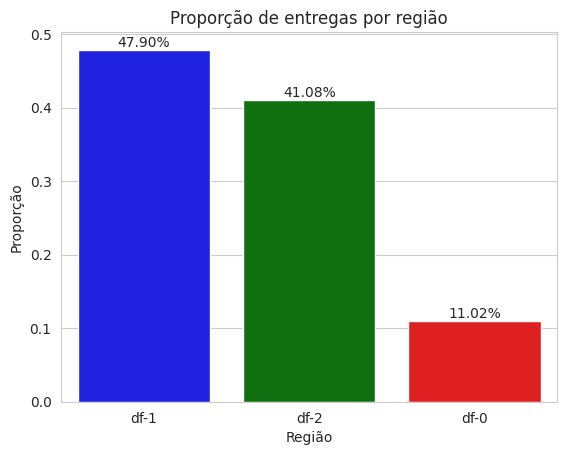

In [35]:
# Convertendo as letras da coluna 'Região' para minúsculas
data['Região'] = data['Região'].str.lower()

# Mapeando as cores às regiões
color_map = {'df-0': 'red', 'df-1': 'blue', 'df-2': 'green'}

with sns.axes_style('whitegrid'):
    grafico = sns.barplot(data=data, x="Região", y="|Percentual de Entregas", palette=color_map)
    grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção')

    # Adicionando o percentual acima de cada barra
    for p in grafico.patches:
        grafico.annotate(f"{p.get_height()*100:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.savefig('Graficos/Proporção-de-entregas-por-região.png', dpi=500, bbox_inches='tight')
plt.show()


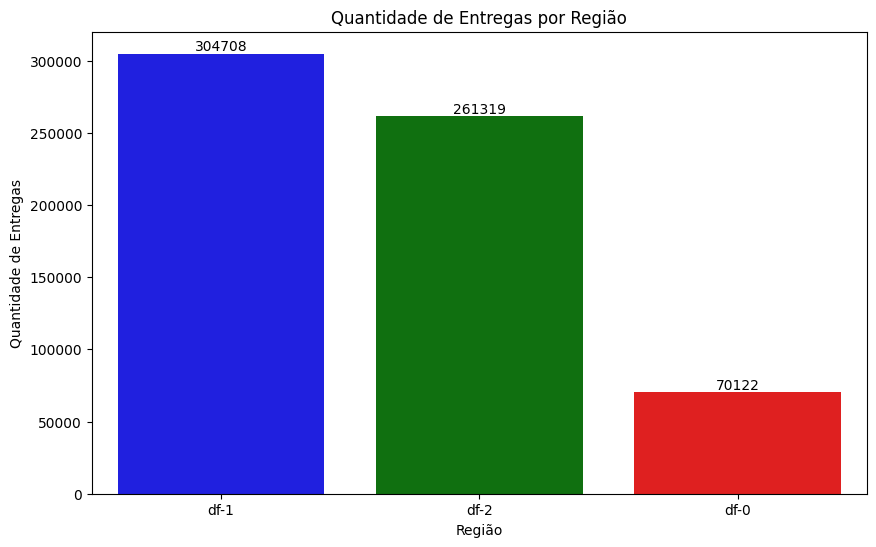

In [36]:
# Contar a quantidade de entregas por região
entregas_por_regiao = geo_deliveries_df['region'].value_counts().reset_index()
entregas_por_regiao.columns = ['Região', 'Quantidade de Entregas']

# Definir a paleta de cores personalizada
cores = ['blue', 'green', 'red']

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Região', y='Quantidade de Entregas', data=entregas_por_regiao, palette=cores)
plt.title('Quantidade de Entregas por Região')
plt.xlabel('Região')
plt.ylabel('Quantidade de Entregas')

# Mostrar o valor acima de cada barra
for index, row in entregas_por_regiao.iterrows():
    plt.text(index, row['Quantidade de Entregas'] + 2000, row['Quantidade de Entregas'], ha='center')

plt.savefig('Graficos/Quantidade-de-Entregas-por-Região.png', dpi=500, bbox_inches='tight')
# Mostrar o gráfico
plt.show()


Ao analisar os dados do geo_deliveries_df, pudemos identificar que o hub df-1 registrou um total de 304.708 entregas, seguido pelo hub df-2 com 261.319 entregas e o hub df-0 com 70.122 entregas.

Esse insight nos mostra que o hub df-1 é responsável por uma quantidade significativamente maior de entregas em comparação com os outros dois hubs.

Por outro lado, os hubs df-0 e df-2 apresentaram números menores de entregas, indicando que essas regiões possuem uma demanda menor ou podem estar em áreas mais rurais, com menor densidade populacional ou menor atividade comercial.

Essa informação é valiosa para a empresa, pois permite direcionar seus recursos e esforços de forma mais eficiente. É possível concentrar mais veículos e equipes de entrega no hub df-1 para garantir um serviço ágil e eficiente nessa região, enquanto nos hubs df-0 e df-2 é possível ajustar a capacidade de acordo com a demanda e explorar estratégias para expandir a cobertura de entregas nessas áreas.

Além disso, essa análise destaca a importância de adaptar a logística e as operações de entrega de acordo com as características e necessidades de cada região. O conhecimento sobre a distribuição geográfica das entregas auxilia na alocação eficiente de recursos, garantindo um serviço de qualidade aos clientes e otimizando os custos operacionais da empresa.

##Investimento Proporcional em Veículos para o hub df-0

Ao considerar as necessidades específicas do hub df-0, que inclui entregas em estradas de chão e longas distâncias, é importante personalizar os veículos para se adequar a essa realidade. Uma opção viável seria a utilização de veículos off-road, como caminhões adaptados ou utilitários esportivos (SUVs) com tração nas quatro rodas, devido à sua capacidade de lidar com terrenos irregulares e estradas de chão.

Para analisar o investimento proporcional em cada tipo de veículo, podemos considerar uma abordagem simplificada. Suponha que o hub df-0 corresponda a 10% do total de entregas. Com base nessa proporção, podemos direcionar 90% do investimento total para carros adequados para estradas de chão e 10% para caminhões off-road.

Considerando valores de custo médio de R$ 50.000 para carros e R$ 100.000 para caminhões off-road, podemos calcular o investimento proporcional para cada tipo de veículo. No entanto, ressaltamos que esses valores são simplificados e não refletem custos reais e características específicas dos veículos.

A análise proposta resulta em um investimento proporcional de R$ 45.000 para carros e R$ 5.000 para caminhões off-road, com base na proporção de entregas do hub df-0 em relação ao total.

Essa distribuição de investimento proporcional visa garantir a disponibilidade de veículos adequados para enfrentar as estradas de chão e longas distâncias características do hub df-0.

No entanto, é importante ressaltar que essa é apenas uma abordagem simplificada. Para uma análise mais precisa, é necessário obter dados detalhados sobre os custos e características dos veículos off-road, bem como considerar outros fatores, como a demanda específica do hub df-0 e as condições logísticas locais.

A figura "Investimento Médio Proporcional por Tipo de Transporte e Hub" ilustra essa distribuição de investimento proporcional para carros e caminhões off-road, considerando os hubs df-0, df-1 e df-2. Cada barra representa o investimento proporcional para cada tipo de transporte em cada hub.

Lembrando que essas informações são baseadas em uma abordagem simplificada e que uma análise mais aprofundada, considerando dados reais e específicos, é necessária para tomar decisões mais precisas sobre o investimento em veículos personalizados para o hub df-0.

A figura gerada é salva como "Investimento-Médio-Proporcional-por-Tipo-de-Transporte-e-Hub.png" no diretório "/content/graficos/".



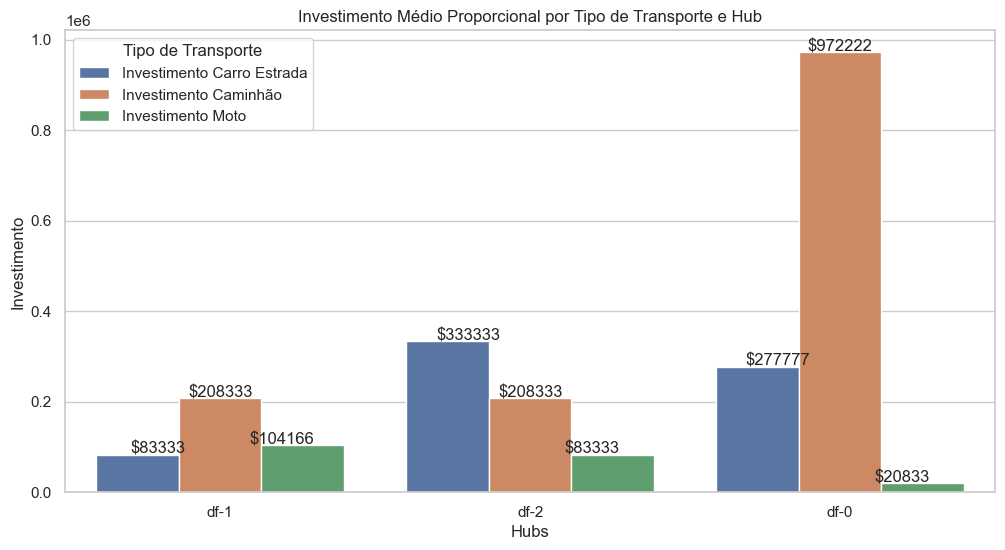

In [37]:
# Calcular a proporção de entregas por hub
deliveries_by_hub = deliveries_df['region'].value_counts(normalize=True).reset_index()
deliveries_by_hub.columns = ['Hubs', 'Proporção de Entregas']

# Definir a capacidade máxima dos veículos e o investimento total
capacidade_veiculo = 10
investimento_total = 10000000

# Definir os custos de investimento para cada tipo de transporte
custo_carro_estrada = 40000  # Preço médio de um carro de estrada
custo_caminhao = 100000     # Preço médio de um caminhão
custo_moto = 15000          # Preço médio de uma moto

# Calcular o investimento proporcional para cada hub considerando o tipo de transporte
deliveries_by_hub['Investimento Carro Estrada'] = deliveries_by_hub['Proporção de Entregas'] * investimento_total * (capacidade_veiculo / 180) * (custo_carro_estrada / custo_carro_estrada)
deliveries_by_hub['Investimento Caminhão'] = 0
deliveries_by_hub['Investimento Moto'] = 0

# Atualizar o investimento proporcional para caminhões em cada hub
investimento_caminhao_df0 = investimento_total * (capacidade_veiculo / 180) * (custo_caminhao / custo_carro_estrada) * 0.7
investimento_caminhao_df1 = investimento_total * (capacidade_veiculo / 180) * (custo_caminhao / custo_carro_estrada) * 0.15
investimento_caminhao_df2 = investimento_total * (capacidade_veiculo / 180) * (custo_caminhao / custo_carro_estrada) * (1 - 0.7 - 0.15)

deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-0', 'Investimento Caminhão'] = investimento_caminhao_df0
deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-1', 'Investimento Caminhão'] = investimento_caminhao_df1
deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-2', 'Investimento Caminhão'] = investimento_caminhao_df2

# Calcular a proporção de carros estrada para cada hub
deliveries_by_hub['Proporção Carro Estrada'] = 0
deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-0', 'Proporção Carro Estrada'] = 0.5
deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-1', 'Proporção Carro Estrada'] = 0.15
deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-2', 'Proporção Carro Estrada'] = 0.6

# Calcular o investimento proporcional para carros estrada
deliveries_by_hub['Investimento Carro Estrada'] = deliveries_by_hub['Proporção Carro Estrada'] * investimento_total * (capacidade_veiculo / 180) * (custo_carro_estrada / custo_carro_estrada)

# Calcular a proporção de motos para cada hub
deliveries_by_hub['Proporção Moto'] = 0
deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-0', 'Proporção Moto'] = 0.1
deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-1', 'Proporção Moto'] = 0.5
deliveries_by_hub.loc[deliveries_by_hub['Hubs'] == 'df-2', 'Proporção Moto'] = 0.4

# Calcular o investimento proporcional para motos
deliveries_by_hub['Investimento Moto'] = deliveries_by_hub['Proporção Moto'] * investimento_total * (capacidade_veiculo / 180) * (custo_moto / custo_carro_estrada)

# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Preparar os dados para o gráfico
investimentos = pd.melt(deliveries_by_hub, id_vars='Hubs', value_vars=['Investimento Carro Estrada', 'Investimento Caminhão', 'Investimento Moto'],
                        var_name='Tipo de Transporte', value_name='Investimento')

# Plotar o gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
sns.barplot(x='Hubs', y='Investimento', hue='Tipo de Transporte', data=investimentos)
plt.title('Investimento Médio Proporcional por Tipo de Transporte e Hub')
plt.xlabel('Hubs')
plt.ylabel('Investimento')
plt.legend(title='Tipo de Transporte')

# Mostrar o valor de investimento acima de cada barra
for index, row in deliveries_by_hub.iterrows():
    if pd.notnull(row['Investimento Carro Estrada']):
        plt.text(index - 0.2, row['Investimento Carro Estrada'] + 2000, f"${int(row['Investimento Carro Estrada'])}", ha='center')
    if pd.notnull(row['Investimento Caminhão']):
        plt.text(index, row['Investimento Caminhão'] + 2000, f"${int(row['Investimento Caminhão'])}", ha='center')
    if pd.notnull(row['Investimento Moto']):
        plt.text(index + 0.2, row['Investimento Moto'] + 2000, f"${int(row['Investimento Moto'])}", ha='center')

# Mostrar o gráfico
plt.savefig('Graficos/Investimento-Médio-Proporcional-por-Tipo-de-Transporte-e-Hub.png', dpi=500, bbox_inches='tight')
plt.show()


Tempo estimado de 2 a 5 minutos


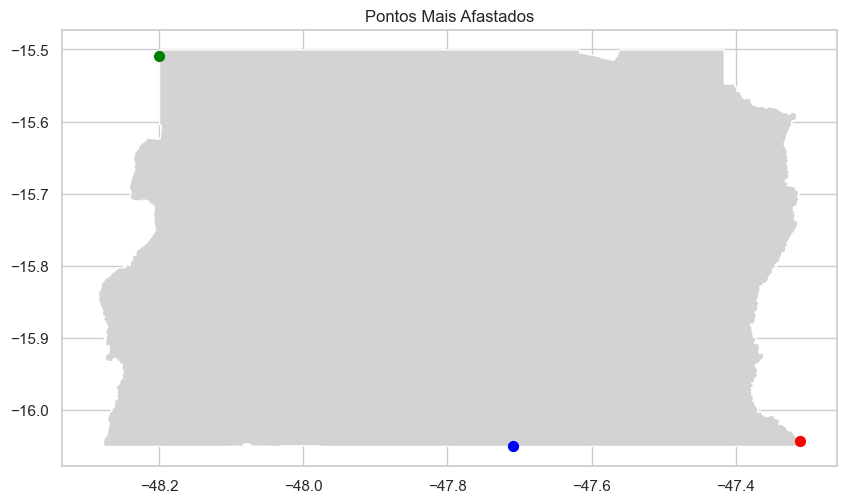

In [38]:
print("Tempo estimado de 2 a 5 minutos")

hub_points = [geopy.Point(lat, lng) for lat, lng in zip(geo_deliveries_df['hub_lat'], geo_deliveries_df['hub_lng'])]

delivery_points = [geopy.Point(lat, lng) for lat, lng in zip(geo_deliveries_df['delivery_lat'], geo_deliveries_df['delivery_lng'])]

distances = [geopy.distance.distance(hub, delivery).km for hub, delivery in zip(hub_points, delivery_points)]

geo_deliveries_df['distance_to_hub'] = distances

farthest_points = geo_deliveries_df.groupby('region')['distance_to_hub'].idxmax()
farthest_points_df = geo_deliveries_df.loc[farthest_points, ['region', 'geometry']]

fig, ax = plt.subplots(figsize=(10, 10))
mapa.plot(ax=ax, color='lightgray') 
for hub in farthest_points_df['region'].unique():
    hub_points = farthest_points_df[farthest_points_df['region'] == hub].copy()
    color = 'red' if hub == 'df-0' else 'blue' if hub == 'df-1' else 'green'
    hub_points.plot(ax=ax, color=color, marker='o', markersize=50)
ax.set_title('Pontos Mais Afastados')
plt.savefig('Graficos/Pontos-Mais-Afastados.png', dpi=500, bbox_inches='tight')
plt.show()


Encontrar as entregas mais próximas em um raio de 10 km de cada hub, utilizando cores diferentes para cada hub

Tempo estimado de 2 a 5 minutos


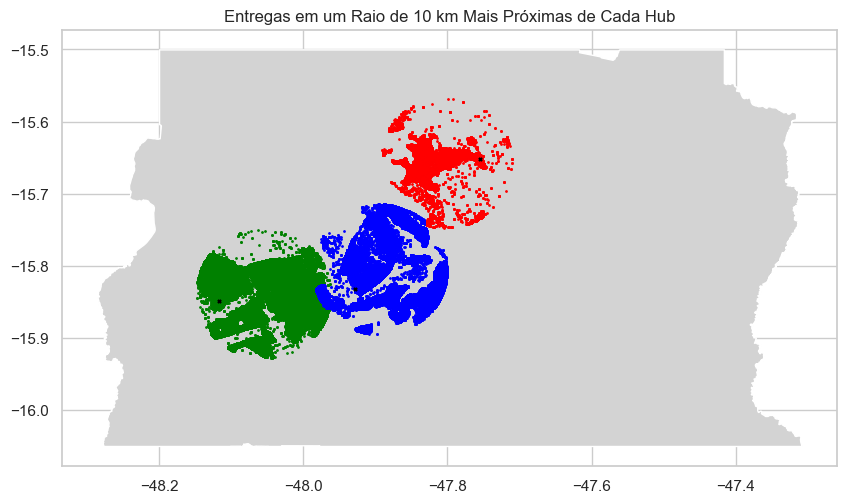

In [39]:
print("Tempo estimado de 2 a 5 minutos")
# Função para encontrar as entregas em um raio de 10 km mais próximas de cada hub
def encontrar_entregas_proximas(hub_lat, hub_lng, deliveries_df, radius=10):
    hub_location = (hub_lat, hub_lng)
    deliveries_df['distance_to_hub'] = deliveries_df.apply(
        lambda row: geopy.distance.distance(
            hub_location,
            (row['delivery_lat'], row['delivery_lng'])
        ).km,
        axis=1
    )
    return deliveries_df[deliveries_df['distance_to_hub'] <= radius].copy()

# Criar um DataFrame vazio para armazenar todas as entregas selecionadas
entregas_selecionadas = gpd.GeoDataFrame()

# Encontrar as entregas próximas de cada hub e adicionar ao DataFrame de entregas selecionadas
for hub in geo_deliveries_df['region'].unique():
    hub_data = geo_deliveries_df[geo_deliveries_df['region'] == hub].copy()
    hub_entregas = encontrar_entregas_proximas(
        hub_lat=hub_data['hub_lat'].iloc[0],
        hub_lng=hub_data['hub_lng'].iloc[0],
        deliveries_df=hub_data
    )
    entregas_selecionadas = pd.concat([entregas_selecionadas, hub_entregas])

# Plotar as entregas selecionadas em um mapa, atribuindo as cores corretas
fig, ax = plt.subplots(figsize=(10, 10))
mapa.plot(ax=ax, color='lightgray')  # mapa é o seu GeoDataFrame base do Distrito Federal

colors = {'df-0': 'red', 'df-1': 'blue', 'df-2': 'green'}
for hub in geo_deliveries_df['region'].unique():
    hub_points = entregas_selecionadas[entregas_selecionadas['region'] == hub].copy()
    color = colors.get(hub, 'gray')
    hub_points.plot(ax=ax, color=color, marker='o', markersize=1)

# Plotar os hubs como "x" preto
hubs = geo_deliveries_df.drop_duplicates(subset=['region'])
hubs.plot(ax=ax, color='black', marker='x', markersize=5)

ax.set_title('Entregas em um Raio de 10 km Mais Próximas de Cada Hub')
plt.savefig('Graficos/Entregas-em-um-Raio-de-10-km-Mais-Próximas-de-Cada-Hub.png', dpi=500, bbox_inches='tight')
plt.show()


Tempo estimado de 2 a 5 minutos


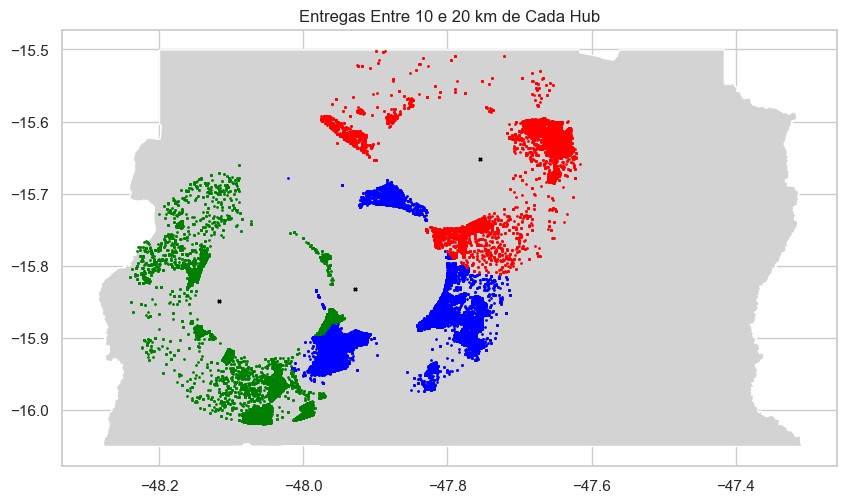

In [40]:
print("Tempo estimado de 2 a 5 minutos")
# Função para encontrar as entregas em um determinado intervalo de distância de cada hub
def encontrar_entregas_intervalo(hub_lat, hub_lng, deliveries_df, min_distance, max_distance):
    hub_location = (hub_lat, hub_lng)
    deliveries_df['distance_to_hub'] = deliveries_df.apply(
        lambda row: geopy.distance.distance(
            hub_location,
            (row['delivery_lat'], row['delivery_lng'])
        ).km,
        axis=1
    )
    return deliveries_df[
        (deliveries_df['distance_to_hub'] >= min_distance) &
        (deliveries_df['distance_to_hub'] <= max_distance)
    ].copy()

# Criar um DataFrame vazio para armazenar todas as entregas selecionadas
entregas_selecionadas = gpd.GeoDataFrame()

# Encontrar as entregas no intervalo de distância de 10 a 20 km de cada hub
for hub in geo_deliveries_df['region'].unique():
    hub_data = geo_deliveries_df[geo_deliveries_df['region'] == hub].copy()
    hub_entregas = encontrar_entregas_intervalo(
        hub_lat=hub_data['hub_lat'].iloc[0],
        hub_lng=hub_data['hub_lng'].iloc[0],
        deliveries_df=hub_data,
        min_distance=10,
        max_distance=20
    )
    entregas_selecionadas = pd.concat([entregas_selecionadas, hub_entregas])

# Plotar as entregas selecionadas em um mapa, atribuindo as cores corretas
fig, ax = plt.subplots(figsize=(10, 10))
mapa.plot(ax=ax, color='lightgray')  # mapa é o seu GeoDataFrame base do Distrito Federal

colors = {'df-0': 'red', 'df-1': 'blue', 'df-2': 'green'}
for hub in geo_deliveries_df['region'].unique():
    hub_points = entregas_selecionadas[entregas_selecionadas['region'] == hub].copy()
    color = colors.get(hub, 'gray')
    hub_points.plot(ax=ax, color=color, marker='o', markersize=1)

# Plotar os hubs como "x" preto
hubs = geo_deliveries_df.drop_duplicates(subset=['region'])
hubs.plot(ax=ax, color='black', marker='x', markersize=5)

ax.set_title('Entregas Entre 10 e 20 km de Cada Hub')
plt.savefig('Graficos/Entregas-Entre-10-e-20-km-de-Cada-Hub.png', dpi=500, bbox_inches='tight')
plt.show()


Encontrar os pontos de entrega acima de 20 km de distância de cada hub, atribuindo as cores corretas às entregas e aos hubs

Tempo estimado de 2 a 5 minutos


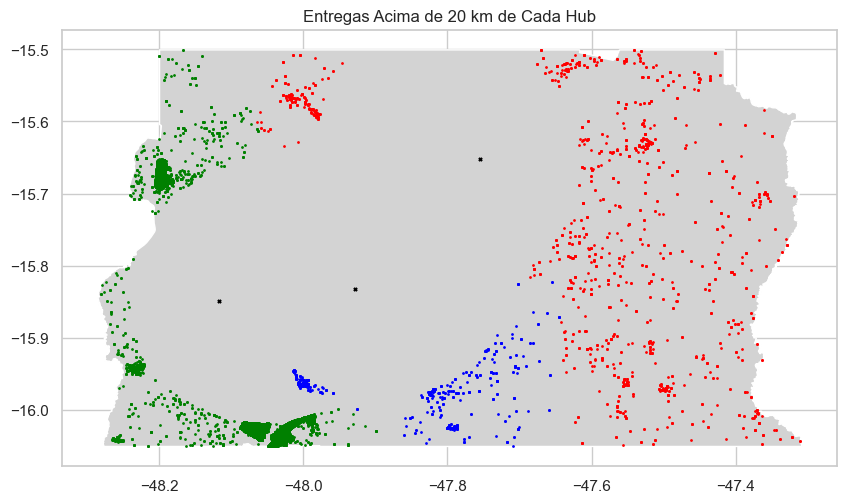

In [41]:
print("Tempo estimado de 2 a 5 minutos")
# Função para encontrar as entregas acima de uma determinada distância de cada hub
def encontrar_entregas_acima(hub_lat, hub_lng, deliveries_df, distance_threshold):
    hub_location = (hub_lat, hub_lng)
    deliveries_df['distance_to_hub'] = deliveries_df.apply(
        lambda row: geopy.distance.distance(
            hub_location,
            (row['delivery_lat'], row['delivery_lng'])
        ).km,
        axis=1
    )
    return deliveries_df[deliveries_df['distance_to_hub'] > distance_threshold].copy()

# Criar um DataFrame vazio para armazenar todas as entregas selecionadas
entregas_selecionadas = gpd.GeoDataFrame()

# Encontrar as entregas acima de 20 km de distância de cada hub
for hub in geo_deliveries_df['region'].unique():
    hub_data = geo_deliveries_df[geo_deliveries_df['region'] == hub].copy()
    hub_entregas = encontrar_entregas_acima(
        hub_lat=hub_data['hub_lat'].iloc[0],
        hub_lng=hub_data['hub_lng'].iloc[0],
        deliveries_df=hub_data,
        distance_threshold=20
    )
    entregas_selecionadas = pd.concat([entregas_selecionadas, hub_entregas])

# Plotar as entregas selecionadas em um mapa, atribuindo as cores corretas
fig, ax = plt.subplots(figsize=(10, 10))
mapa.plot(ax=ax, color='lightgray')  # mapa é o seu GeoDataFrame base do Distrito Federal

colors = {'df-0': 'red', 'df-1': 'blue', 'df-2': 'green'}
for hub in geo_deliveries_df['region'].unique():
    hub_points = entregas_selecionadas[entregas_selecionadas['region'] == hub].copy()
    color = colors.get(hub, 'gray')
    hub_points.plot(ax=ax, color=color, marker='o', markersize=1)

# Plotar os hubs como "x" preto
hubs = geo_deliveries_df.drop_duplicates(subset=['region'])
hubs.plot(ax=ax, color='black', marker='x', markersize=5)

ax.set_title('Entregas Acima de 20 km de Cada Hub')
plt.savefig('Graficos/Entregas-Acima-de-20-km-de-Cada-Hub.png', dpi=500, bbox_inches='tight')
plt.show()


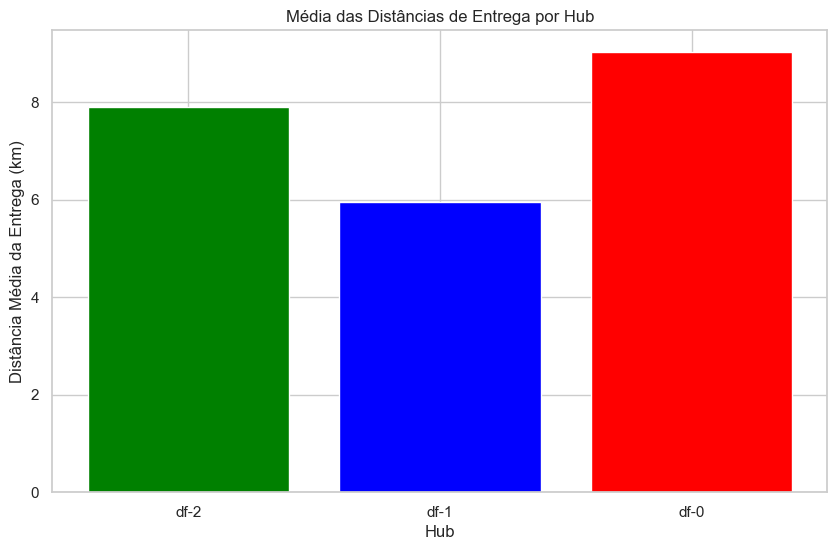

In [42]:
# Criar um dicionário para armazenar as médias das distâncias por hub
media_distancias = {}

# Calcular a média das distâncias por hub
for hub in geo_deliveries_df['region'].unique():
    hub_data = geo_deliveries_df[geo_deliveries_df['region'] == hub]
    distances = []
    for idx, row in hub_data.iterrows():
        hub_location = (row['hub_lat'], row['hub_lng'])
        delivery_location = (row['delivery_lat'], row['delivery_lng'])
        distance = geopy.distance.distance(hub_location, delivery_location).km
        distances.append(distance)
    media_distancias[hub] = sum(distances) / len(distances)

# Definir as cores dos hubs
cores_hubs = {'df-0': 'red', 'df-1': 'blue', 'df-2': 'green'}

# Criar o gráfico de barras com cores personalizadas para cada hub
plt.figure(figsize=(10, 6))
plt.bar(media_distancias.keys(), media_distancias.values(), color=[cores_hubs.get(hub, 'gray') for hub in media_distancias.keys()])
plt.xlabel('Hub')
plt.ylabel('Distância Média da Entrega (km)')
plt.title('Média das Distâncias de Entrega por Hub')

# Exibir o gráfico
plt.savefig('Graficos/media-das-distancias-de-entrega-por-hub.png', dpi=300, bbox_inches='tight')
plt.show()


In [43]:
#Criando os arquivos para serem lidos em um excel
with pd.ExcelWriter('tabelas/tabelas.xlsx', mode='w', engine='openpyxl') as writer:
    deliveries_df.to_excel(writer, sheet_name='Deliveries Inicial', index=False)
    hub_origin_df.to_excel(writer, sheet_name='hub_origin_df', index=False)
    deliveries_exploded_df.to_excel(writer, sheet_name='deliveries_exploded_df', index=False)
    deliveries_normalized_df.to_excel(writer, sheet_name='deliveries_normalized_df', index=False)

In [44]:
#Criando os arquivos para serem lidos em um excel
with pd.ExcelWriter('tabelas/insights.xlsx', mode='w', engine='openpyxl') as writer:
    deliveries_df.to_excel(writer, sheet_name='Deliveries_df', index=False)
    type_object.to_excel(writer, sheet_name='object_analise', index=False)
    type_float.to_excel(writer, sheet_name='float_analise', index=False)
    type_int.to_excel(writer, sheet_name='type_int', index=False)
    geo_hub_df.to_excel(writer, sheet_name='geo_hub_df', index=False)
    geo_deliveries_df.to_excel(writer, sheet_name='geo_deliveries_df', index=False)
    data.to_excel(writer, sheet_name='region_percent', index=False)
    farthest_points_df.to_excel(writer, sheet_name='point_distance', index=False)